# Activity 2.2. Regularization
In this activity, we do not intend to implement any regularization. Instead, we use an available packages called `glmnet` which implements various regularisers (e.g. $\ell_1$, $\ell_2$, and a combination of the two which is called the "elastic net"), and study its output.   

In particular, we are interested to study the performance of each regularization technique in dealing with informative (predictive), redundant and irrelavant features in terms of prediction accuracy (residuals) and model complexity (the number of nonzero coefficients).



# Steps for Activity 2.2
<ol>
	<li>For $\alpha\in\{0, 1\}$ (corresponding to Ridge and LASSO regression, respectively) repeat the following steps:
<ol>
	<li>Use `glmnet` function to calculate the coefficients `a0` and `beta` and the number of nonzero coefficient `df` (as a measure of complexity) for $\lambda\in\{0, 0.01,\dots, 1\}$</li>
	<li>Plot the coefficients vs $\lambda$  </li>
	<li>Plot the number of nonzero coefficients <code>df</code> vs $\lambda$  </li>
</ol>
<li>Generate redundant features and repeat the `for` loop in Step 1. As an example, assuming that length in cm is one of the features, we can add redundant features by adding the length in mm, inch, etc as additional features.</li>

</ol>

# Implementation of the Above Steps
### Dataset
Let start with loading libraries and datasets.

In [1]:
library(glmnet)       # for regresion models + l1 (LASSO), l2 (Ridge) and l1/l2 (Ealstic Net) regularizations
library(ggplot2)      # for plotting functions.
library(reshape2)     # for melt and cast functions
library(car)          # for Davis datasets (you may access the dataset from other sources)
library(DataExplorer) # For basic EDA

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Loading required package: carData


In [2]:
data(Davis) # Read more about this dataset: https://vincentarelbundock.github.io/Rdatasets/doc/car/Davis.html
head(Davis) # repwt and repht are the reported weight and reported height respectively.

sex,weight,height,repwt,repht
<fct>,<int>,<int>,<int>,<int>
M,77,182,77,180
F,58,161,51,159
F,53,161,54,158
M,68,177,70,175
F,59,157,59,155
M,76,170,76,165


In this example, we use a simple dataset containingthe self-reported as well as measured values for the heights and weights of some people. Let us take a look at the dataset first, and then do the activities!

In [3]:
dim(Davis) # 200 records

[1] 200   5

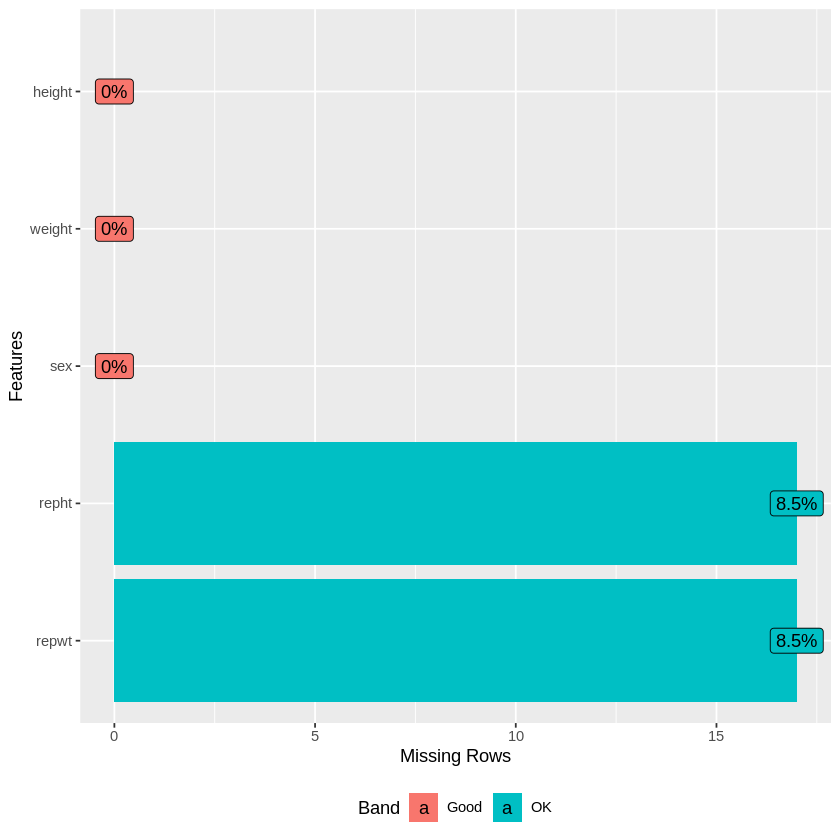

In [4]:
plot_missing(Davis)

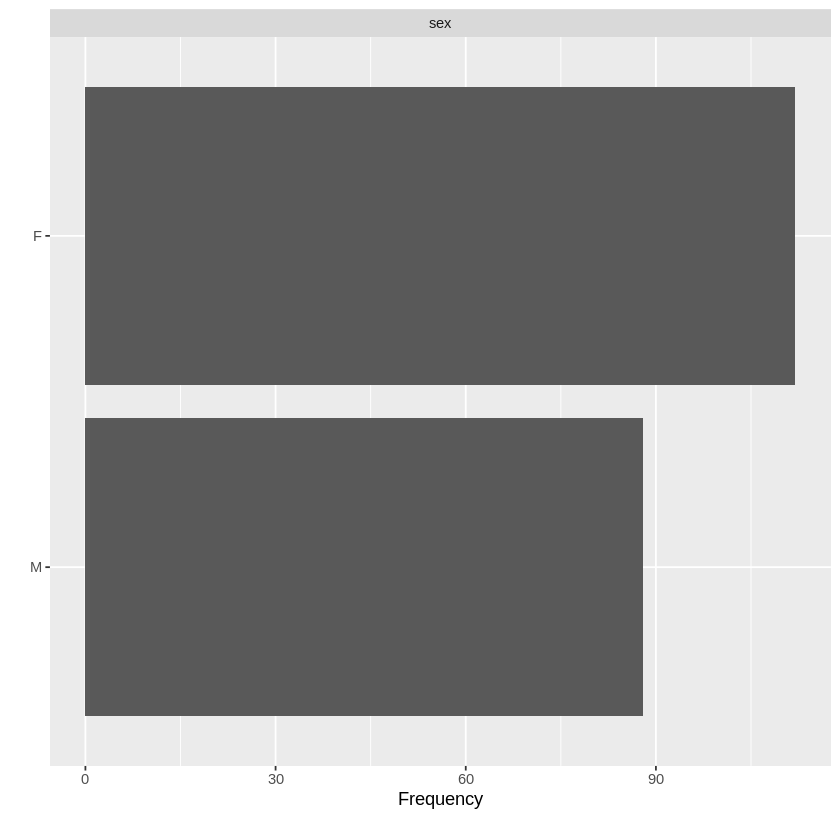

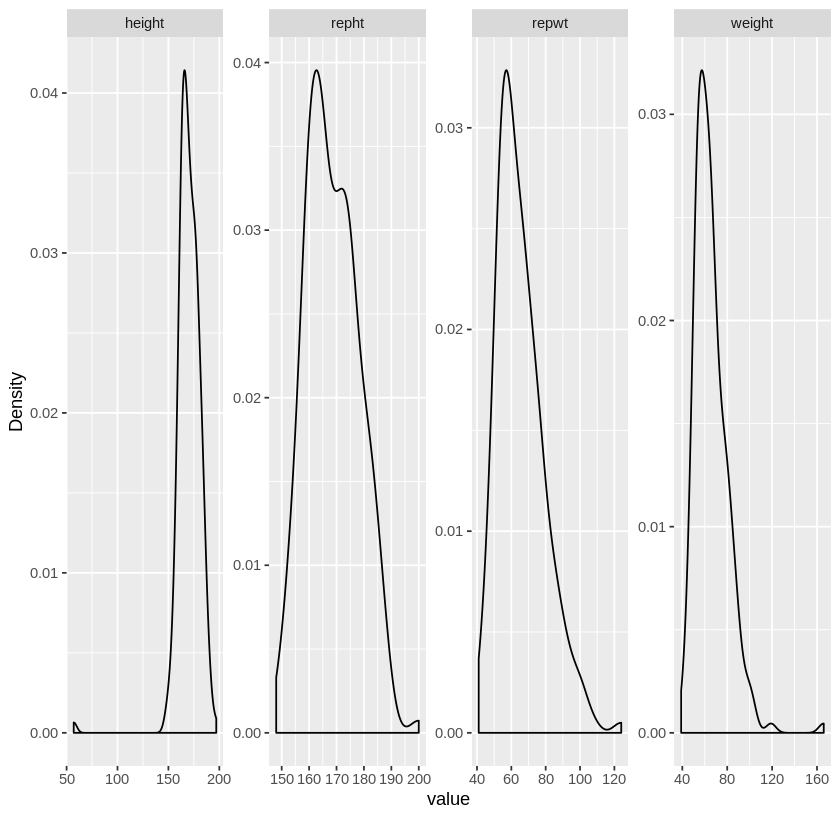

In [5]:
plot_bar(Davis)
plot_density(Davis)

In [6]:
Davis <- na.exclude(Davis) # excluding NA values

In [7]:
Davis <- Davis[-12,]       # excluding an outlier

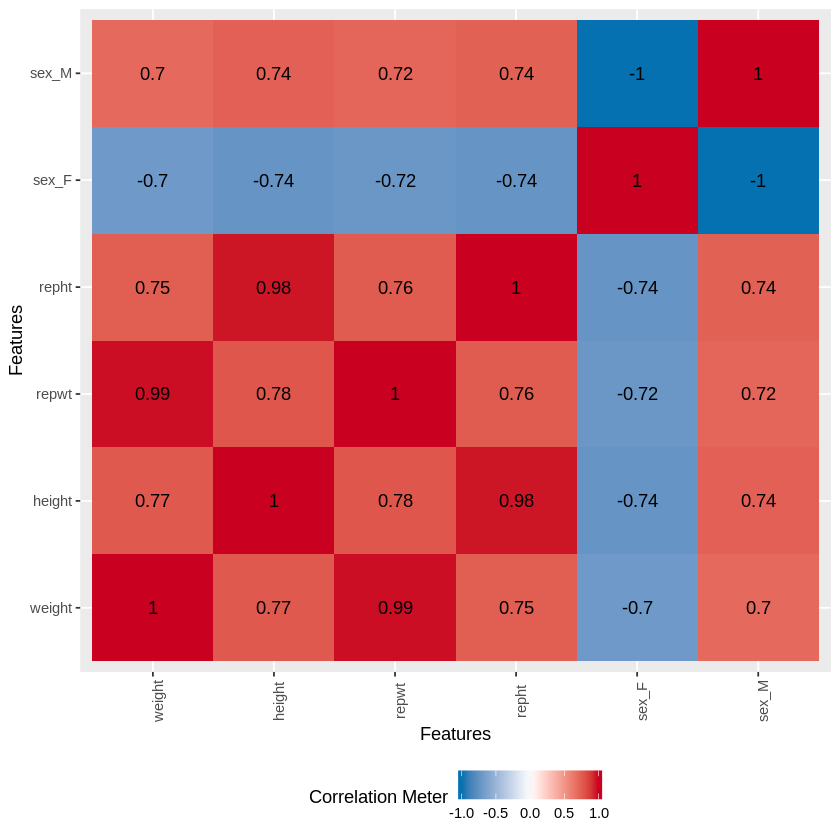

In [8]:
plot_correlation(Davis)

### Train and Test Sets
Now, the task is to predict the measured `weight` based on people's measured `height`, reported height `repht` and reported weight `repwt` (note that `sex` is excluded). Before going further, we divide the data into training and testing sets. 

In [9]:
train.index <- sample(1:nrow(Davis),90)  # We're choosing a sample of 90 for the training set
train.data  <- Davis[train.index, c('height', 'repwt', 'repht')]
train.label <- Davis[train.index, 'weight']
test.data   <- Davis[-train.index, c('height', 'repwt', 'repht')]
test.label  <- Davis[-train.index, 'weight']

### Auxilary Functions
Before going further, we develop an auxiliary finction called `fitAndPlot` to reduce the amount of repeated works. This function uses `glmnet` function to build a model and plot its outputs.

The `glmnet` function has several interesting input arguments and output values. In particular, we use `alpha` to select the type of regularization (`0`:**Ridge** and `1`:**LASSO**) and `lambda` to set a range for the regularization parameter. Some of the interesting outputs are `a0`, `beta`, and `df` indicating the intercept, coefficients, and the number of nonzero coefficients, respectively.

In [10]:
fitAndPlot <- function(train.data, train.label, alpha=0, lambda = c(0:5000)/1000){
    
    # fit the model
    fit <- glmnet(x = as.matrix(train.data), y = train.label, alpha = alpha, lambda = lambda)

    # aggrigate the outputs - take the beta output of fit and transpose it (t) then add df and lambda values
    out <- as.data.frame(as.matrix(t(fit$beta)))
    out[,c('nonzero', 'lambda')] <- c(fit$df, fit$lambda)

    # reshape the outputs (for plotting)
    out.m<-melt(out, id=c('lambda', 'nonzero'))
    names(out.m) <- c('lambda', 'nonzero', 'feature', 'coefficient')

    # plot coefficients vs lambda 
    g <- ggplot(data = out.m, aes(x=lambda, y=coefficient, color=factor(feature))) + 
        geom_line() +
        ggtitle('Coefficients vs. lambda') + 
        theme_minimal()
    print(g)
    
    # plot number of nonzero coefficients (as ameasure of model complexity) vs lambda 
    g <- ggplot(data = out.m, aes(x=lambda, y=nonzero)) + 
        geom_line() + 
        scale_y_continuous(breaks=seq(0,10,1)) +
        scale_color_discrete(guide = guide_legend(title = NULL)) + 
        ggtitle('Nonzero Coefficients vs. lambda') + 
        theme_minimal()
    print(g)
    
    # run the predictions
    train.predict <- predict(fit, newx=as.matrix(train.data))
    test.predict <- predict(fit, newx=as.matrix(test.data))

    # calculate the errors
    error <- data.frame('lambda' = out$lambda, 
                    'train' = sqrt(colSums((train.predict - train.label)^2)/nrow(train.predict)),
                    'test' = sqrt(colSums((test.predict - test.label)^2)/nrow(test.predict)))
    error.m <- melt(error, id='lambda')
    names(error.m) <- c('lambda', 'set', 'RMSE')

    # plot sum of squarred error for train and test sets vs lambda 
    g <- ggplot(data = error.m, aes(x=lambda, y = RMSE, color = factor(set))) + 
        geom_line() +  
        ylim(0,6) +
        scale_color_discrete(guide = guide_legend(title = NULL)) + 
        ggtitle('RMSE vs. lambda') + 
        theme_minimal()
    print(g)
}

### Ridge Regression on Informative Features

Let us begin with buidling Ridge regression models and plotting the outputs

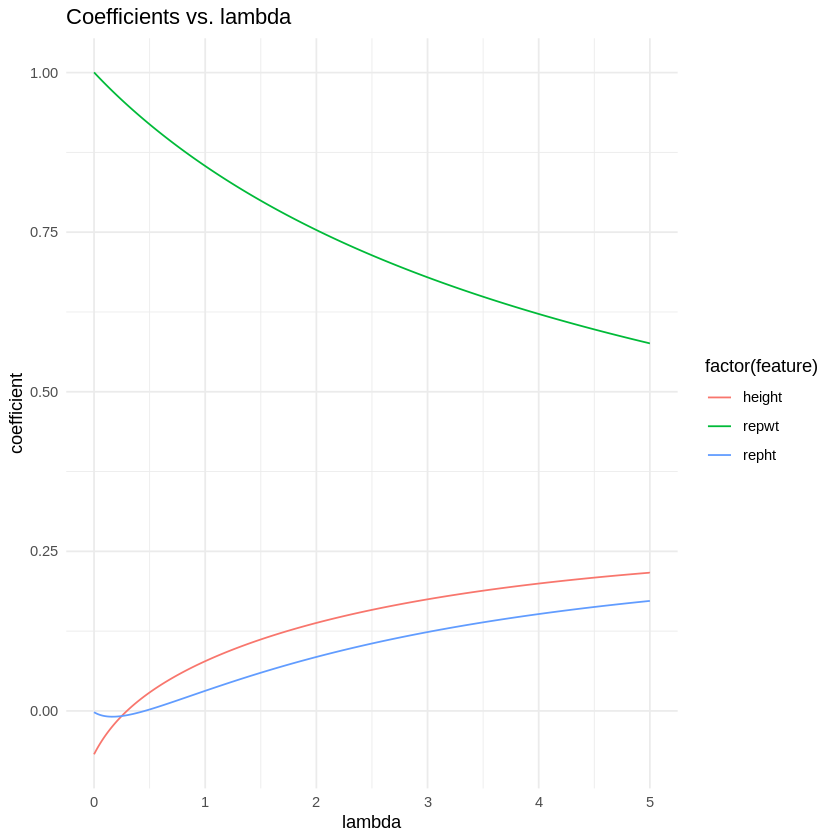

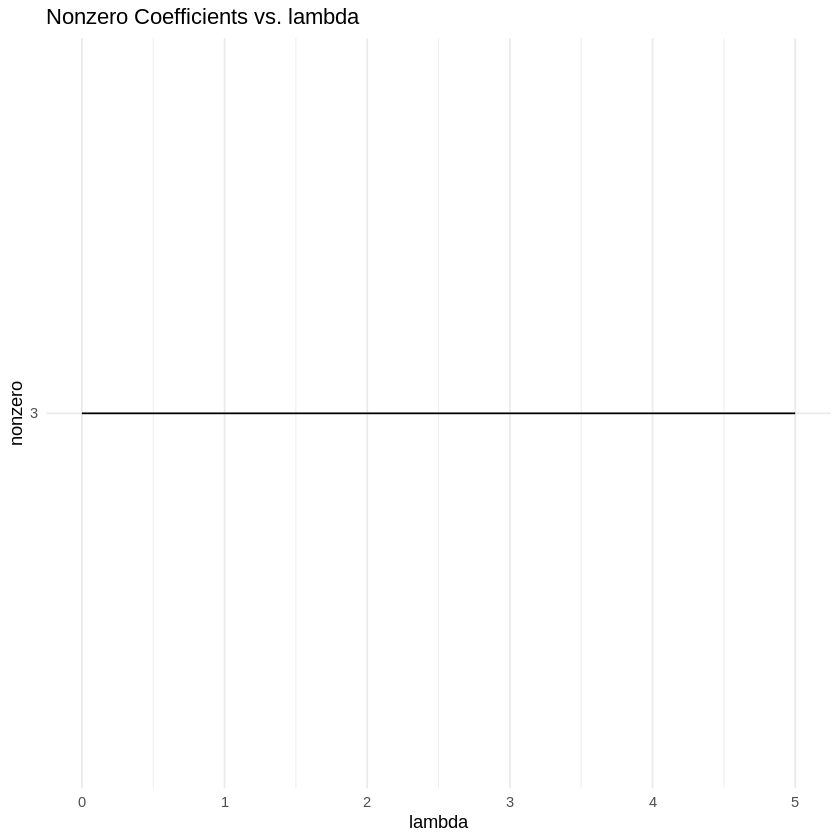

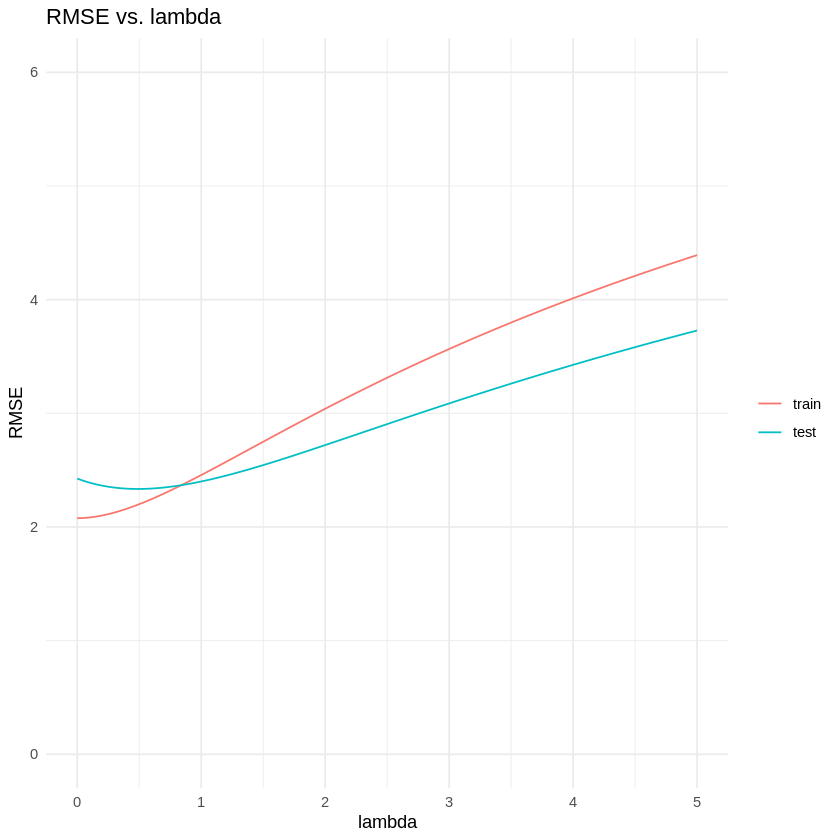

In [11]:
fitAndPlot (train.data, train.label, alpha=0, lambda = c(0:5000)/1000)

The first plot shows that the coefficients remain nonzero as $\lambda$ increases. In other words, the sparsity of the model (aka the number of zero coefficients) does not increase as the regularization parameter increases. However, we already know that a sparser model exists which can accurately predict the target, due to the fact that the measured weight (target) can be predicted well by the self-reported weight feature. This shows that ridge regression doesn't tend to learn sparse models.

The second plot shows the testing and training error of the learned models as $\lambda$ increases. Can you identify the underfitting and overfitting regions?

### LASSO on Informative Features
To repeat the above steps for LASSO, we only need to change the value of `alpha`. From the definition of $\ell_1$ norm, we expect LASSO to learn sparser models (more zero coefficients). 

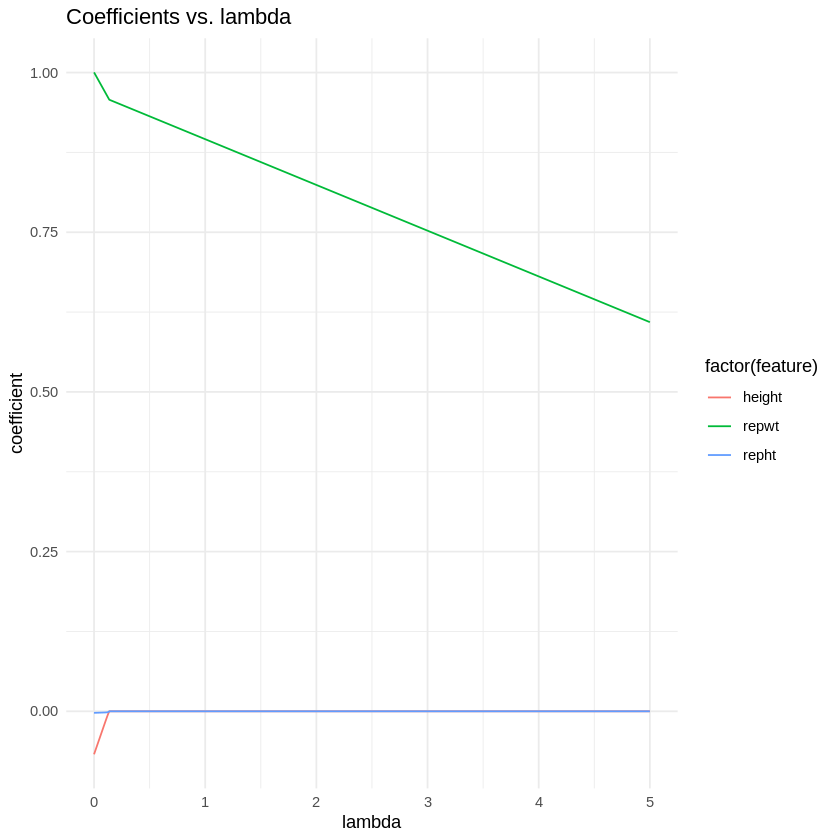

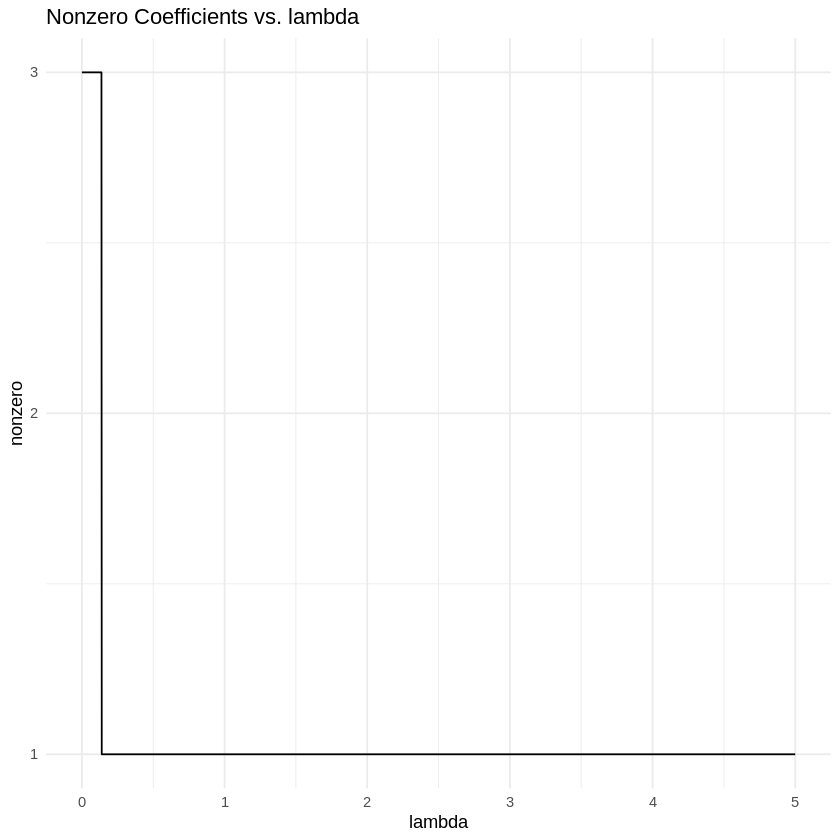

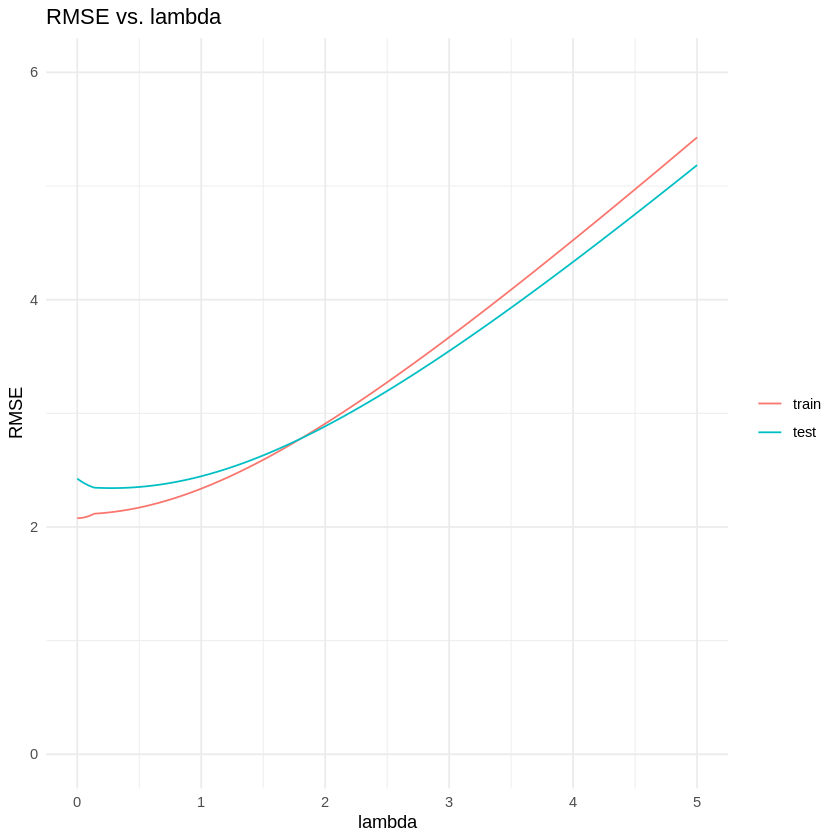

In [12]:
fitAndPlot (train.data, train.label, alpha=1, lambda = c(0:5000)/1000)

The first plot shows that the coefficients tent to zero as $\lambda$ increases. In other words, the learned model becomes sparser as the regularisation parameter increases. Note the surviving feature (the one with nonzero weight) when the regularisation parameter is large (yes, it is the reported weight feature). 

The second plot shows the testing and training error of the learned models as $\lambda$ increases. Can you identify the underfitting and overfitting regions?

### Generating Redundant Features
Now, we intend to increase the dimesion of our data set by adding some extra redundant features. Recal that we originally had heights in cm, and weight in kg. Let us add heights and weight in other metric systems:

In [13]:
# first rename the original features
names(train.data) <- c('height.cm', 'repwt.kg', 'repht.cm')
names(test.data) <- c('height.cm', 'repwt.kg', 'repht.cm')

# add heights in inch and cm
train.data$height.inch <- train.data$height.cm /2.54 
train.data$repht.mm <- train.data$repht.cm * 10 

test.data$height.inch <- test.data$height.cm /2.54 
test.data$repht.mm <- test.data$repht.cm * 10 

# add weight in g and pounds
train.data$repwt.lbs <- train.data$repwt.kg * 2.2046
train.data$repwt.g <- train.data$repwt.kg * 1000

test.data$repwt.lbs <- test.data$repwt.kg * 2.2046
test.data$repwt.g <- test.data$repwt.kg * 1000

... and adding the difference between the reported and measured heights.

,height.cm,repwt.kg,repht.cm,height.inch,repht.mm,repwt.lbs,repwt.g,height.overestimate,height.underestimate
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
88,165,53,165,64.96063,1650,116.8438,53000,0,0
147,165,55,165,64.96063,1650,121.2530,55000,0,0
39,178,86,175,70.07874,1750,189.5956,86000,3,0
192,173,86,173,68.11024,1730,189.5956,86000,0,0
180,174,68,173,68.50394,1730,149.9128,68000,1,0
175,168,64,168,66.14173,1680,141.0944,64000,0,0


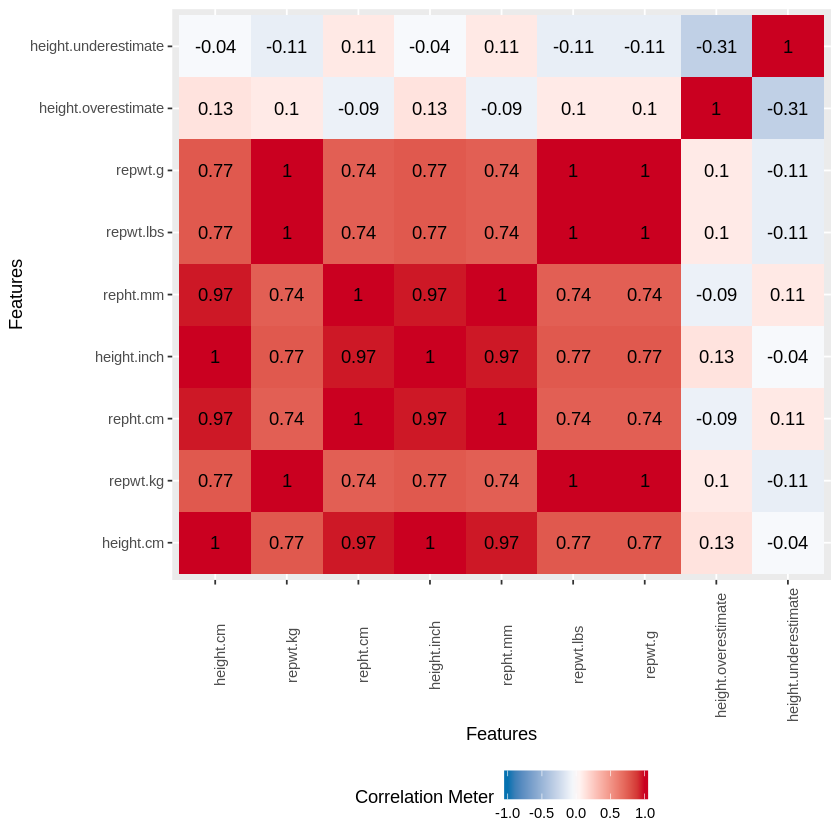

In [14]:
# add height differences
train.data$height.overestimate <- ifelse(train.data$height.cm>train.data$repht.cm, train.data$height.cm - train.data$repht.cm, 0)
train.data$height.underestimate <- ifelse(train.data$height.cm<train.data$repht.cm, train.data$repht.cm - train.data$height.cm, 0) 

test.data$height.overestimate <- ifelse(test.data$height.cm>test.data$repht.cm, test.data$height.cm - test.data$repht.cm, 0)
test.data$height.underestimate <- ifelse(test.data$height.cm<test.data$repht.cm, test.data$repht.cm - test.data$height.cm, 0)

head(train.data)
plot_correlation(train.data)


#### Ridge Regression on Redundant Features
Now, it is time to repeat the previous experiment using the new data set augmented with extra additional features.

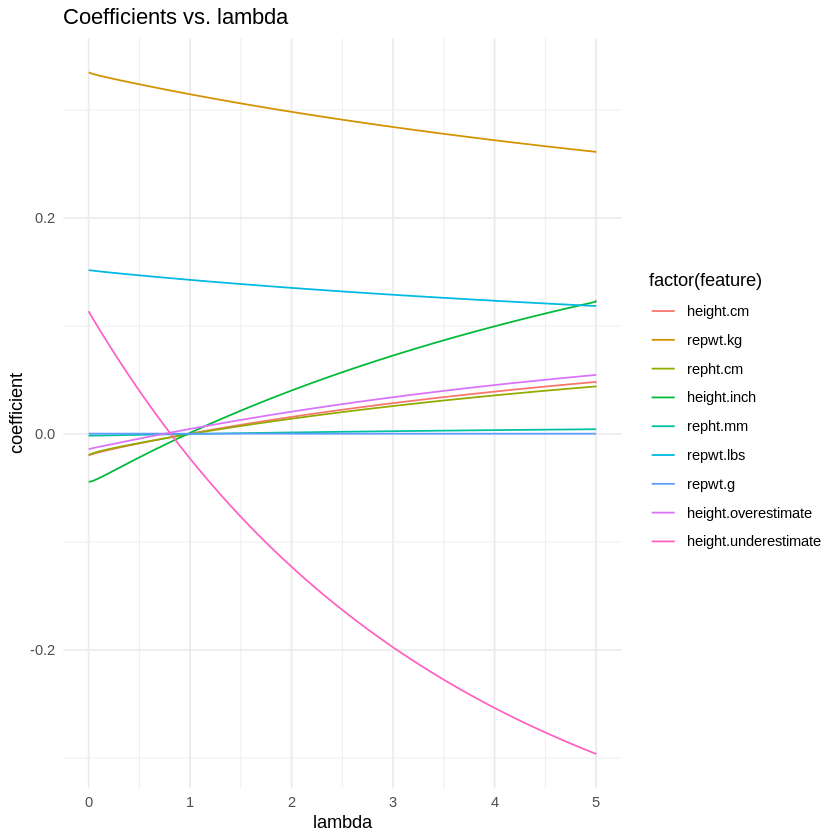

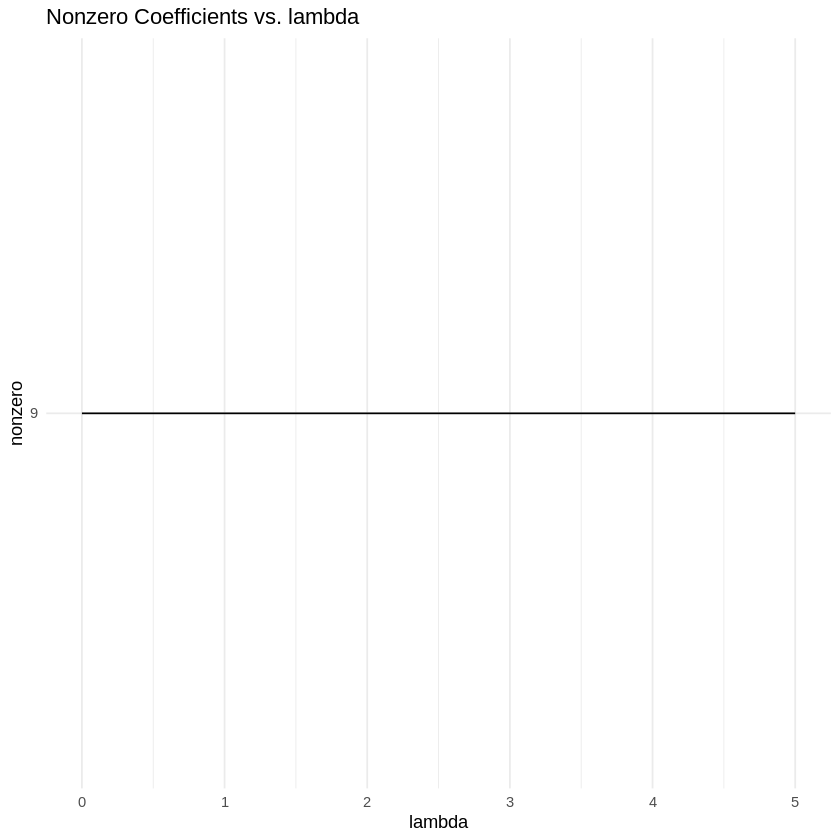

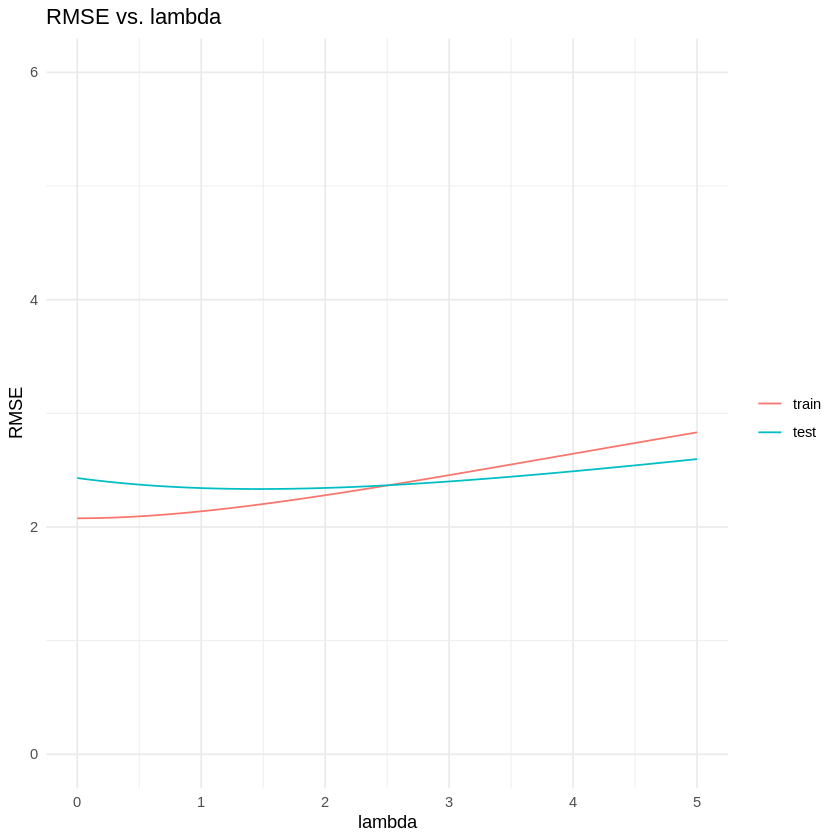

In [15]:
# learn and plot Ridge regressions
fitAndPlot (train.data, train.label, alpha=0, lambda = c(0:5000)/1000)

Consider some redundant features, e.g. height in cm and inch. As $\lambda$ increases, what happens to the coefficients of these two redundant features? As we can see from the plot, both of them get nonzero coefficients and the model does not tend to choose one of them and zero out the other one.

### LASSO on Redundant Features
Now, let's repeat the previous experiment with LASSO.

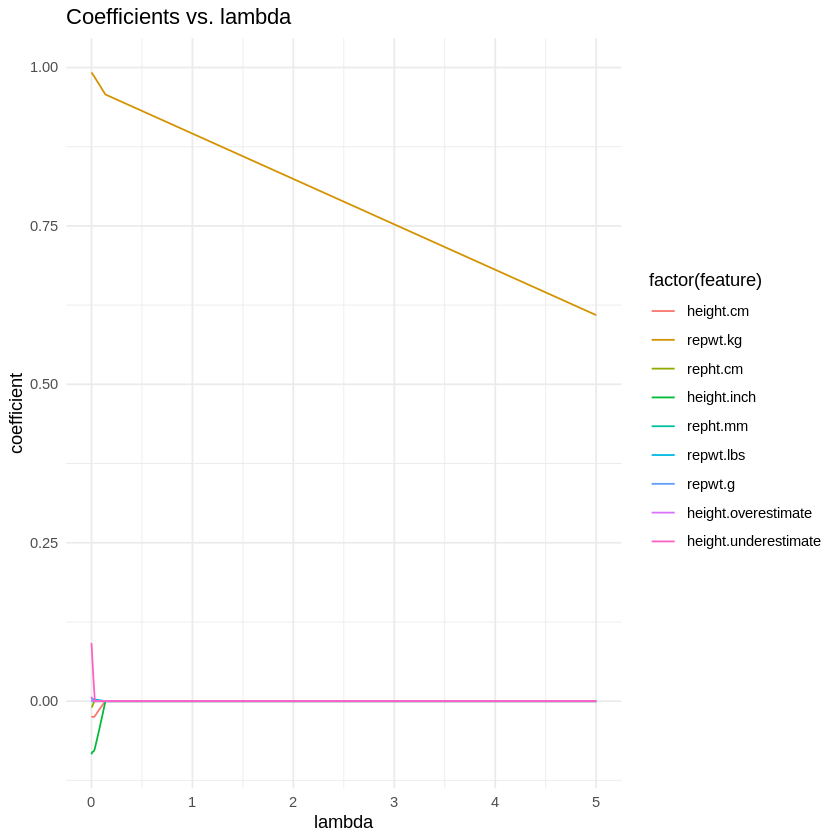

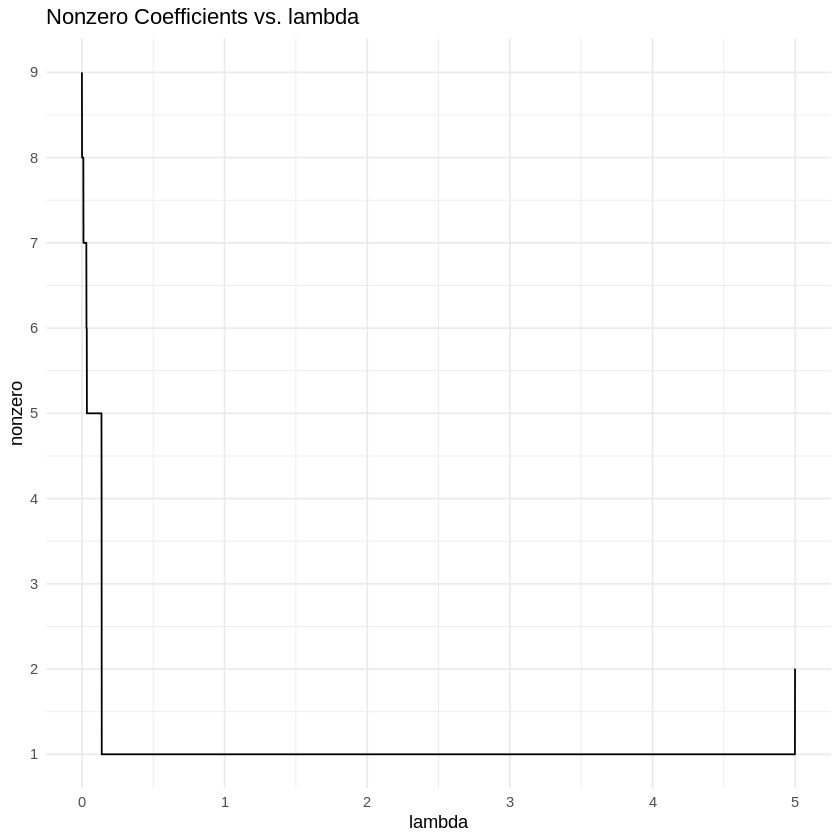

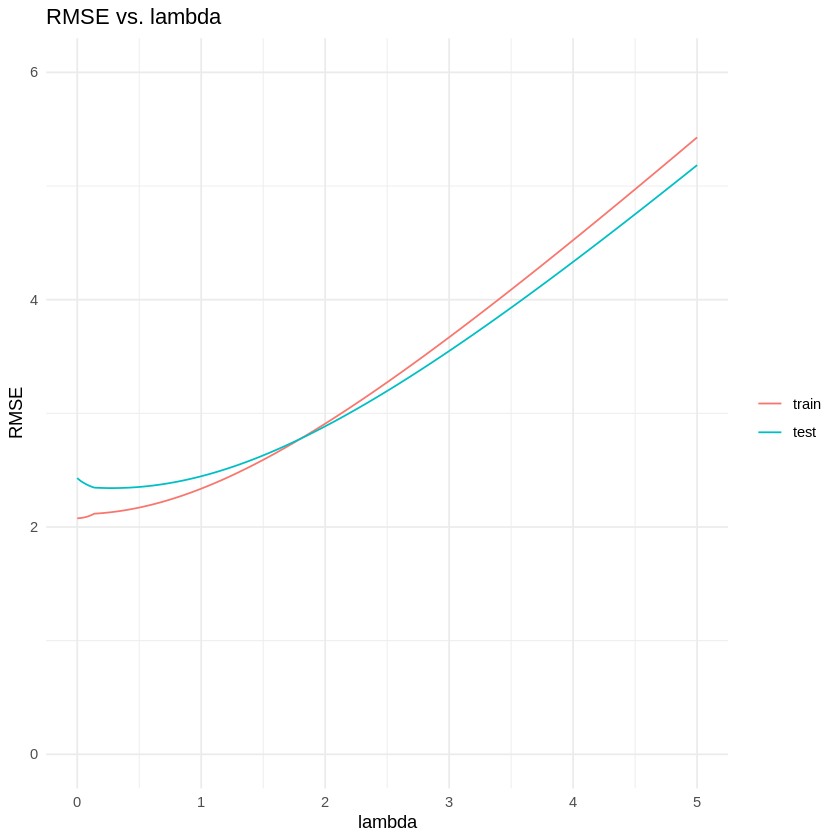

In [16]:
# learn and plot LASSO regressions
fitAndPlot (train.data, train.label, alpha=1, lambda = c(0:5000)/1000)

Consider some redundant features, e.g. height in cm and inch. As $\lambda$ increases, the model tend to choose one of them and zero out the coefficient of other one.

## Discussions
<ol>
<li>Generally, what are the differences between the models learned by $\ell_1$ and $\ell_2$ regularisation?</li>
        <li> Which regulariser can  be used as feature selection algorithm?</li>
        <li> Which one builds models with better generalization (train error and test error must be as close as possible)?
	<li>How can we find the optimum values for $\lambda$? (think about the techniques covered in Module 1)</li>
</ol>